In [5]:
# import numpy as np
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt

from astropy.table import Table

import manhattan.periodograms as cs 
from scipy.signal import savgol_filter
from astropy.stats import LombScargle

%matplotlib inline
pl.rcParams['figure.dpi']= 150

## Basis Pursuit for Spectrum Estimation

Following Chen & Donoho, "APPLICATION OF BASIS PURSUIT IN SPECTRUM ESTIMATION"

https://pdfs.semanticscholar.org/1bb0/74529d4a5d56cc9d05befcc3dcde957420fb.pdf

We want to be able to infer the power spectrum of a signal which is sparse in the Fourier domain, given potentially sparse, irregularly sampled time series. Using an L1 norm algorithm, we can fit simultaneously a sum of sines, cosines, polynomial terms, and Dirac delta functions to represent outliers, and get a pretty decent fit.

We have a similar approach to Hara et al., 'Radial velocity data analysis with compressed sensing techniques'.

http://adsabs.harvard.edu/abs/2017MNRAS.464.1220H

In [18]:
time = np.linspace(0,100,1000)
y = np.zeros_like(time)

inputs = [1., 2., 2.5, 4.3] # to do it manually
amps = [1., 0.2, 3., 0.5]

inputs = np.random.rand(10)*5. # to randomly generate some frequencies
amps = np.random.rand(10)+0.5

for j, f in enumerate(inputs): 
    y += amps[j]*np.sin(f*time)
    
snr = 50. # dial it down to add more white noise

y += (y.max()/snr) * np.random.randn(len(y))

y = (y-y.min())/(y.max()-y.min())

args = np.sort(np.random.choice(len(time),size=100,replace=False)) # only choose 100 points, at random

tt, yy = time[args], y[args]


In [19]:
np.unique(args).shape

(100,)

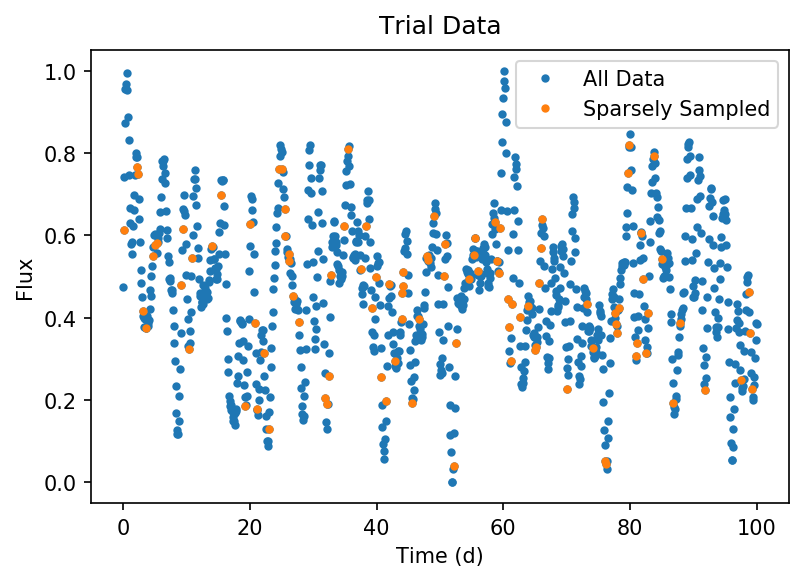

In [20]:
plt.plot(time,y,'.',label="All Data")
plt.plot(tt,yy,'.',label="Sparsely Sampled")
plt.xlabel("Time (d)")
plt.ylabel("Flux")
plt.legend()
plt.title("Trial Data",y=1.01);

### For basis pursuit: 
https://github.com/drrelyea/SPGL1_python_port 

### minimize ||x||_1 subject to Ax = b




In [38]:
%%time
output = cs.basis_pursuit(tt, yy, nfreqs=500, fmin=0.1, fmax=10, polyorder=2, C

CPU times: user 68.5 ms, sys: 8.15 ms, total: 76.6 ms
Wall time: 39.5 ms


In [39]:
power = (output['sines']**2 + output['cosines']**2)
freqs = output['freqs']
diracs = output['diracs']
polys = output['polys']
residuals = output['resid']
print(output['polys'])

[-0.  0.  0.]


In [40]:
pf = np.poly1d(polys)

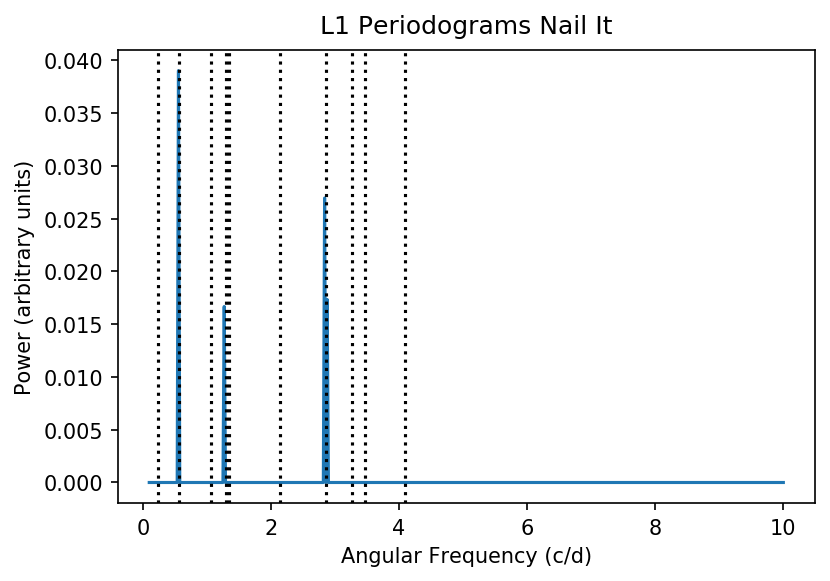

In [41]:
# pl.plot(freqs,output['sines'])
# pl.plot(freqs,output['cosines'])

pl.plot(freqs, np.sqrt(power))
pl.xlabel("Angular Frequency (c/d)")
pl.ylabel("Power (arbitrary units)")
pl.title("L1 Periodograms Nail It", y=1.01);

for f in inputs:
    pl.axvline(f, color='k', ls=':')

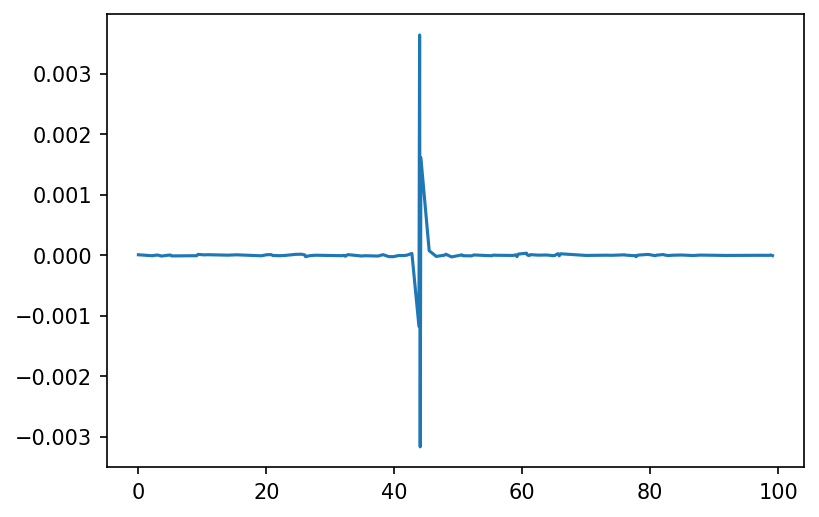

In [33]:
plt.plot(tt,residuals,label="Residuals")

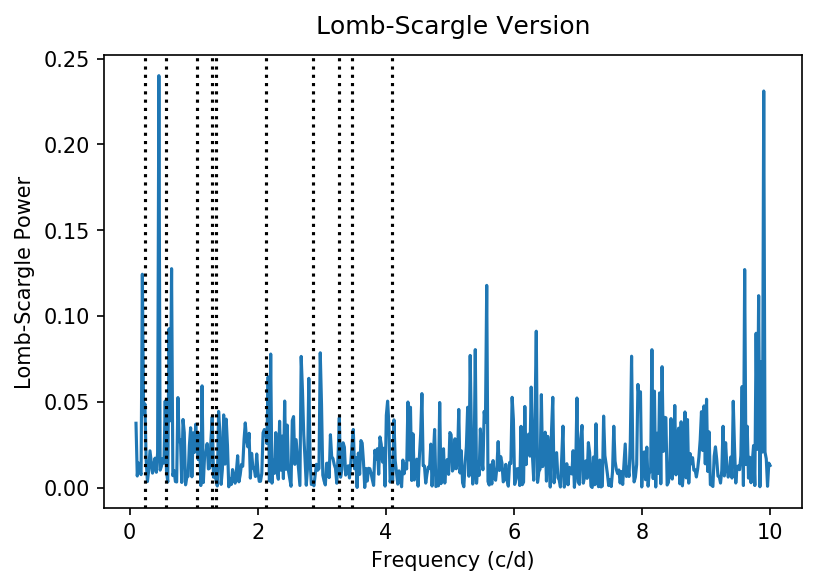

In [26]:
# %%time
## lomb-scargle
from astropy.stats import LombScargle
power = LombScargle(tt, yy).power(freqs)
pl.plot(freqs, power) 
pl.xlabel("Frequency (c/d)")
pl.ylabel("Lomb-Scargle Power")
pl.title("Lomb-Scargle Version", y=1.02)

for f in inputs:
    pl.axvline(f, color='k', ls=':')

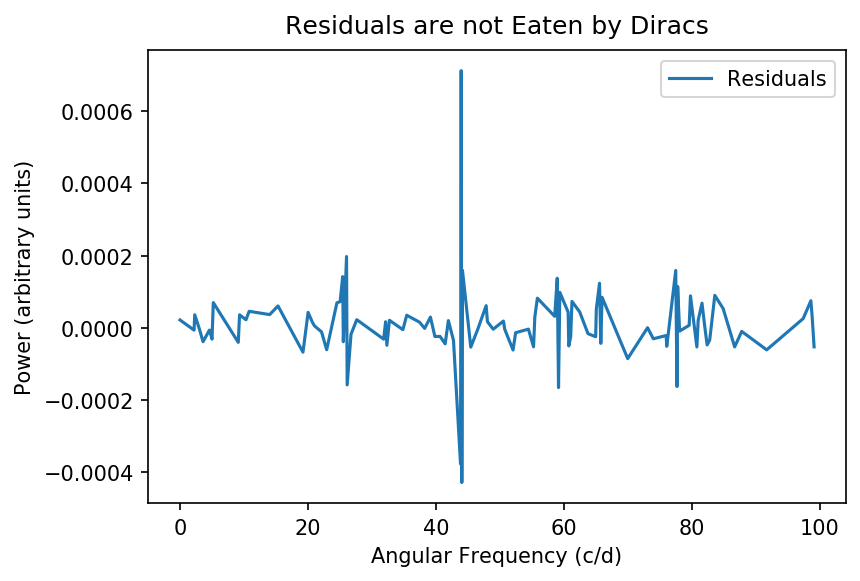

In [28]:
plt.plot(tt,diracs,label="Diracs")
plt.plot(tt,residuals,label="Residuals")
plt.xlabel("Angular Frequency (c/d)")
plt.ylabel("Power (arbitrary units)")
plt.legend()
plt.title("Residuals are not Eaten by Diracs",y=1.01);

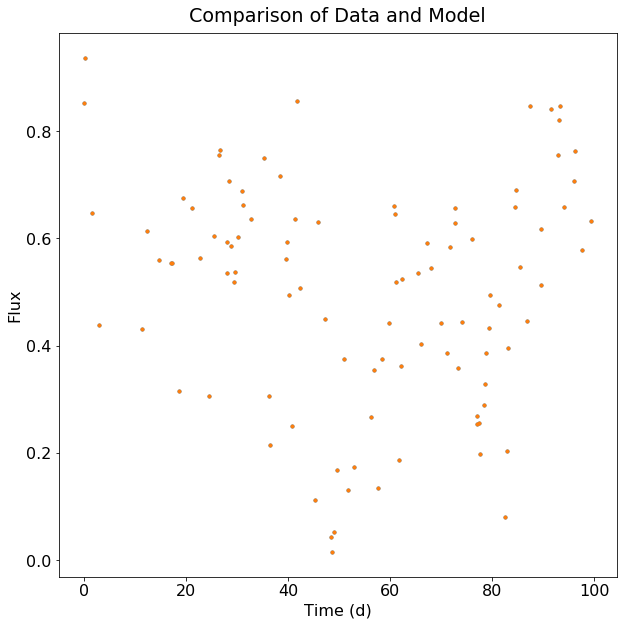

In [10]:
plt.title("Comparison of Data and Model",y=1.01)
plt.plot(tt,yy,'.')
plt.plot(tt,output['model'],'.')
plt.xlabel("Time (d)")
plt.ylabel("Flux");

### How does this perform as you reduce the number of samples?

In [405]:
%%time
recovered = []
lss = []
sizes = [10,20,30,40,50,100,200,500,1000]
times = np.linspace(0,100,np.max(sizes))
# sizes = [10,20,30,40]

ys = np.sin(times) + 0.1*np.random.randn(np.size(times))

for sz in sizes:
    print sz
    args = np.sort(np.random.choice(len(time),size=sz,replace=False))

    tt, yy = times[args], ys[args]
    output = cs.basis_pursuit(tt,yy,fmin=0.03,fmax=2,nfreqs=1000)
    power = (output['sines']**2 + output['cosines']**2)
    freqs = output['freqs']
    pls = LombScargle(tt,yy).power(freqs)
    
    recovered.append(freqs[np.argmax(power)])
    lss.append(freqs[np.argmax(pls)]*2*np.pi)
    
recovered = np.array(recovered)
lss = np.array(lss)

10
20
30
40
50
100
200
500
1000
CPU times: user 21min 18s, sys: 9.51 s, total: 21min 28s
Wall time: 7min 10s


In [406]:
lss

array([1.00180328, 1.00056537, 1.00056537, 1.00056537, 0.99932746,
       0.99932746, 1.00056537, 1.00056537, 1.00056537])

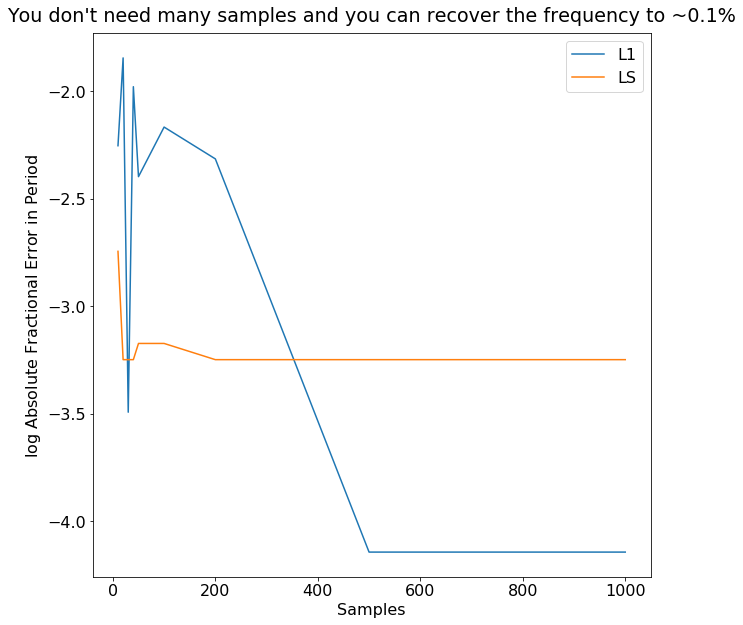

In [407]:
plt.plot(sizes,np.log10(np.abs(1.-recovered)),label="L1")
plt.plot(sizes,np.log10(np.abs(1.-lss)),label="LS")

plt.ylabel(r"$\log$ Absolute Fractional Error in Period")
plt.xlabel("Samples")
plt.title("You don't need many samples and you can recover the frequency to ~0.1%",y=1.01)
plt.legend()

1.00056536981388


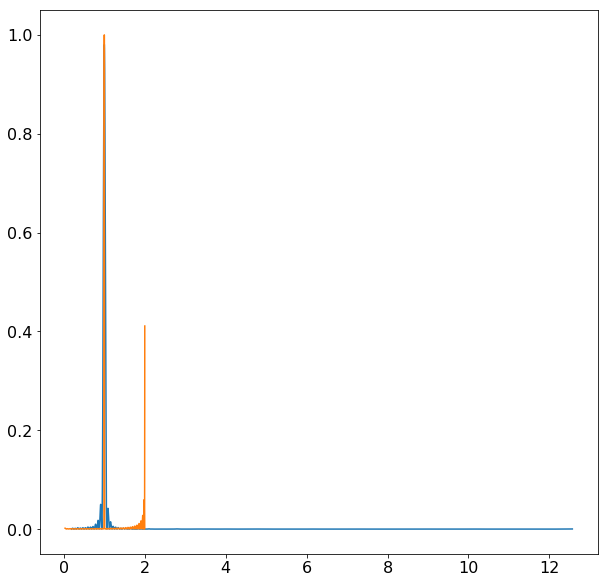

In [408]:
plt.plot(freqs*2*np.pi,pls)
plt.plot(freqs,power/power.max())
print freqs[np.argmax(pls)]*2*np.pi

### How does this perform on real data?

In [409]:
ls /Users/benjaminpope/code/manhattan/data/

HD_178875_smear_full.csv              kplr008881697-2011177032512_llc.fits
HR7487/                               kplr100002056-2010174085026_llc.fits


In [410]:
# fname = '../data/HD_178875_smear_full.csv' # HD178875 smear light curve
# name = "HD178875"

# lc = Table.read(fname,format='csv') # HD178875
# lc = lc[np.isfinite(lc['FLUX'])]

# lc = lc[2700:5000]
# args = np.sort(np.random.choice(len(lc['BJD']),size=100,replace=False)) # only choose 100 points, at random
# lc = lc[args]
# time, flux = lc['BJD'], lc['FLUX']
# flux -= savgol_filter(flux,11,2)
# error = flux/1000.

In [411]:
# fname = '../data/HR7487/kplr009411865_kasoc-ts_llc_v2.dat' # red giant HR7487 smear light curve
# name = 'HR7487'

# lc = Table.read(fname,format='ascii') # HR7487
# m = np.isfinite(lc['Flux'])
# lc = lc[m]
# # args = np.sort(np.random.choice(len(lc['Time']),size=1000,replace=False)) # only choose 100 points, at random
# lc = lc[:1500]
# # lc = lc[args]

# time, flux, error = lc['Time'], lc['Flux'], lc['Error']
# flux -= savgol_filter(flux,11,2)
# m = (np.abs(flux)<200.)
# time, flux, error = time[m], flux[m], error[m]

In [462]:
fname = '../data/kplr100002056-2010174085026_llc.fits' # rr Lyrae itself
fname = '../data/kplr008881697-2011177032512_llc.fits'
name = 'RR Lyr'
name = 'Kepler 8881697'

lc = Table.read(fname) # use this for RR Lyr and similarly formatted things
lc = lc[np.isfinite(lc['PDCSAP_FLUX'])]
print 'LC Length',np.size(lc['PDCSAP_FLUX'])

args_100 = np.sort(np.random.choice(len(lc['TIME']),size=500,replace=False))
args_1000 = np.sort(np.random.choice(len(lc['TIME']),size=1000,replace=False))
args = args_100.copy()
# lc = lc[args_1000]
print lc.keys()
time, flux, error = lc['TIME'], lc['PDCSAP_FLUX'], lc['PDCSAP_FLUX_ERR']

LC Length 4610
['TIME', 'TIMECORR', 'CADENCENO', 'SAP_FLUX', 'SAP_FLUX_ERR', 'SAP_BKG', 'SAP_BKG_ERR', 'PDCSAP_FLUX', 'PDCSAP_FLUX_ERR', 'SAP_QUALITY', 'PSF_CENTR1', 'PSF_CENTR1_ERR', 'PSF_CENTR2', 'PSF_CENTR2_ERR', 'MOM_CENTR1', 'MOM_CENTR1_ERR', 'MOM_CENTR2', 'MOM_CENTR2_ERR', 'POS_CORR1', 'POS_CORR2']


In [454]:
time -= time.min()

<Container object of 3 artists>

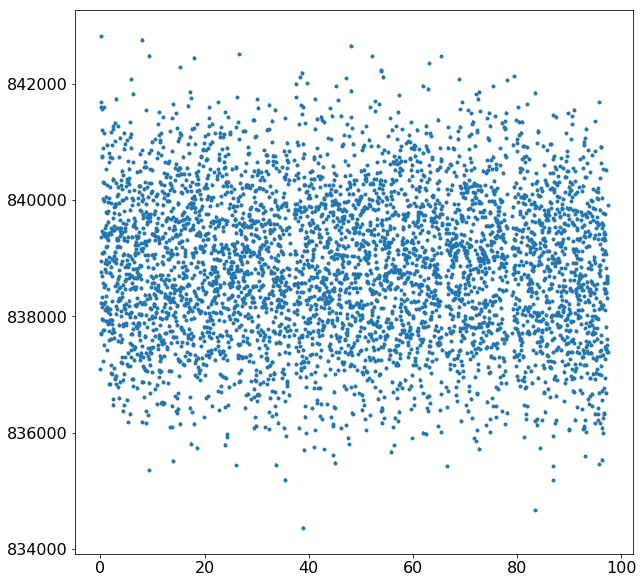

In [455]:

plt.plot(time,flux,'.')
plt.errorbar(time,flux,yerr=error,linestyle="none")
# plt.xlim(180,181)

In [472]:
%%time
# results_100 = cs.basis_pursuit(time[args_100],flux[args_100],fmin=0.1,fmax=12*2*np.pi,nfreqs=2000,polyorder=4,noise=False)
# results_1000 = cs.basis_pursuit(time[args_1000],flux[args_1000],fmin=0.1,fmax=12*2*np.pi,nfreqs=2000,polyorder=4,noise=False)
results = cs.basis_pursuit(time[args_100],flux[args_100],fmin=0.1,fmax=20*2*np.pi,nfreqs=2000,polyorder=4,noise=False)


CPU times: user 7.74 s, sys: 86.5 ms, total: 7.83 s
Wall time: 6.5 s


CPU times: user 57.4 ms, sys: 3.11 ms, total: 60.5 ms
Wall time: 58.7 ms


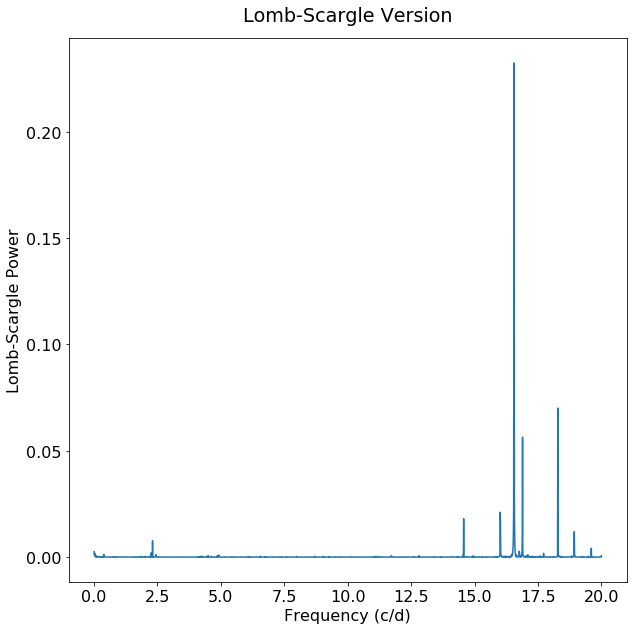

In [478]:
%%time
## lomb-scargle
pls = LombScargle(lc['TIME'].data, lc['PDCSAP_FLUX']).power(frequency=results['freqs']/2./np.pi)
plt.plot(results['freqs']/2./np.pi, pls) 
# plt.yscale('log')
plt.xlabel("Frequency (c/d)")
plt.ylabel("Lomb-Scargle Power")
plt.title("Lomb-Scargle Version", y=1.02)

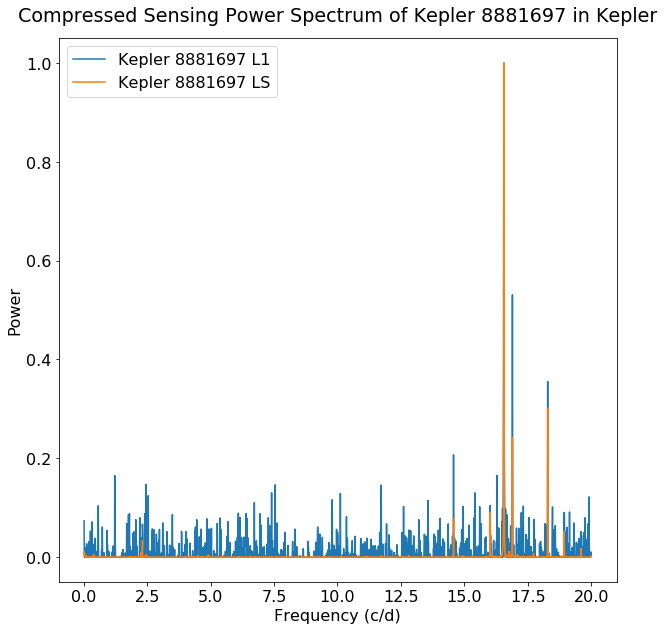

In [479]:
# power_100 = results_100['power']
# power_1000 = results_1000['power']
power = results['power']
# plt.plot(results_100o['freqs']/2./np.pi,power_1000,label="1000 Samples")
# plt.plot(results_100['freqs']/2./np.pi,power_100,label="100 Samples")
plt.plot(results['freqs']/2./np.pi,np.sqrt(power/power.max()),label="%s L1" % name)
plt.plot(results['freqs']/2./np.pi, pls/pls.max(),label='%s LS' % name) 

# plt.yscale("log")
# plt.xlim(0,15)
plt.xlabel("Frequency (c/d)")
plt.ylabel("Power")
plt.title("Compressed Sensing Power Spectrum of %s in Kepler" % name,y=1.02)
plt.legend()
plt.savefig('%s_cspec.png' % name)

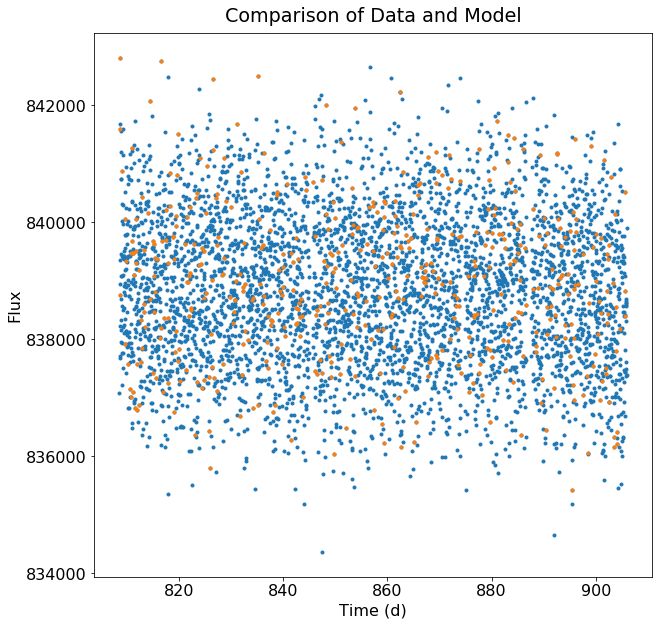

In [475]:
plt.title("Comparison of Data and Model",y=1.01)
plt.plot(time,flux,'.')
plt.plot(time[args],results['model'],'.')
plt.xlabel("Time (d)")
plt.ylabel("Flux");

In [306]:
# plt.plot(results['diracs'])

### Did it work for our red giant? 

In [196]:
ps = Table.read('../data/HR7487/kplr009411865_kasoc-psd_llc_v2.pow',format="ascii")

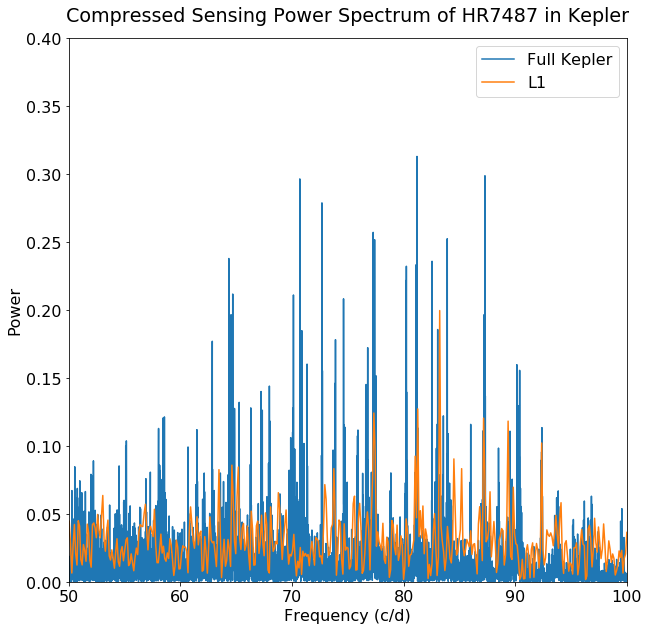

In [210]:
plt.plot(ps['col1'],ps['col2']/ps['col2'].max(),label="Full Kepler")
fmax = 70
m = results['freqs']<fmax
plt.plot(results['freqs'][m]/2./np.pi*11.57,power[m]/power.max(),label="L1")
plt.yscale("linear")
plt.xlim(50,100)
plt.ylim(0,0.4)
plt.xlabel("Frequency (c/d)")
plt.ylabel("Power")
plt.title("Compressed Sensing Power Spectrum of %s in Kepler" % name,y=1.02)
plt.legend()
plt.savefig('comparison.png')